In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [2]:
data=pd.DataFrame()
data=wb.DataReader('MSFT',data_source='yahoo',start='2015-01-1',end='2020-01-01')

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.539135
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,41.157158
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,40.553074
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,41.068310
2015-01-08,47.750000,46.720001,46.750000,47.590000,29645200.0,42.276463
...,...,...,...,...,...,...
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,155.730255
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,157.006729
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,157.293686


C:\Users\dixit\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


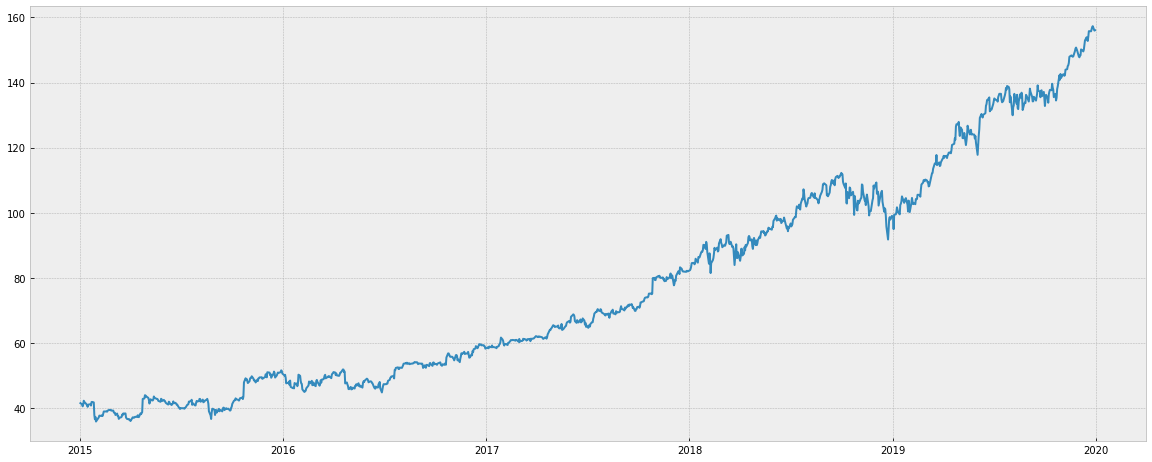

In [4]:
plt.figure(figsize=(20,8))
plt.plot(data['Adj Close']);

Text(0.5, 1.0, 'MSFT daily return')

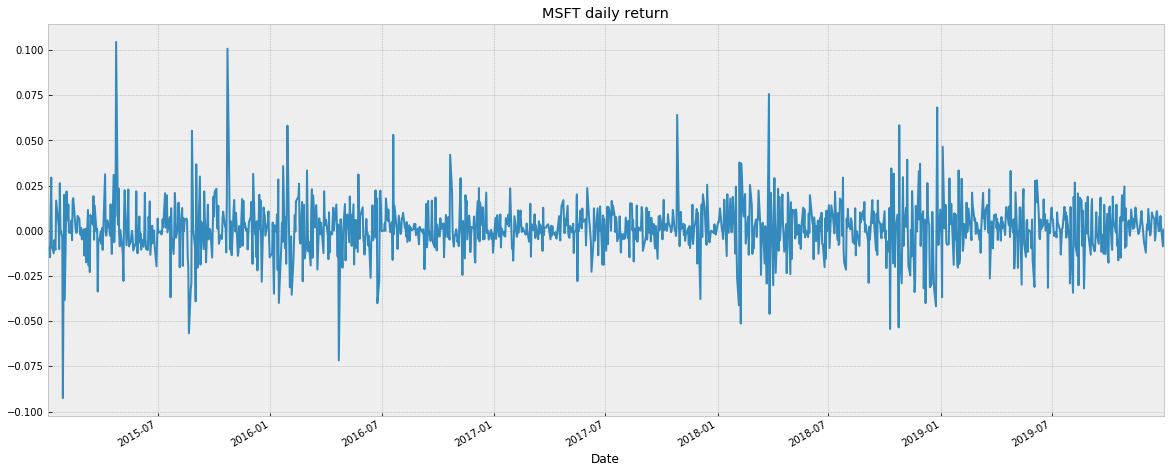

In [21]:
plt.figure(figsize=(20,8))
data['Adj Close'].pct_change().plot()
plt.title("MSFT daily return")


Let’s see whether the daily returns are better represented by a normal distribution or by a Student-t distribution.

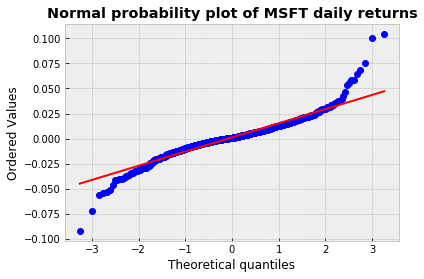

In [31]:
Q = data["Adj Close"].pct_change().dropna()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title("Normal probability plot of MSFT daily returns", weight="bold");

((array([-0.11465943, -0.08432606, -0.07157001, ...,  0.07401012,
          0.08676618,  0.11709954]),
  array([-0.09253364, -0.07171036, -0.05672333, ...,  0.07570512,
          0.10077039,  0.10452213])),
 (0.9799425258016639, -3.468168183330222e-05, 0.996035653251473))

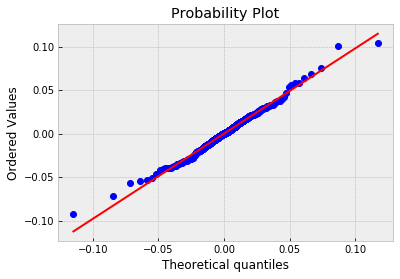

In [27]:
returns=data['Adj Close'].pct_change().dropna()
mean=returns.mean()
sigma=returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns)
scipy.stats.probplot(returns, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))

Student’s t distribution does seem to fit better (look in particular at the tails of the distribution).

# Value at Risk using the historical bootstrap method

Text(0.5, 1.0, 'Histogram of MSFT daily returns')

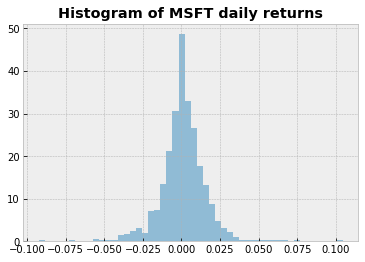

In [28]:
returns.hist(bins=50, density=True, histtype="stepfilled",alpha=0.5);
plt.title("Histogram of MSFT daily returns",weight="bold")

In [29]:
returns.quantile(0.05)

-0.021067880797347605

## The 0.05 empirical quantile of daily returns is at -0.021. That means that with 95% confidence, our worst daily loss will not exceed 2.1%. If we have a 1 M dollar investment, our one-day 5% VaR is 0.021 * 1 M  = $ 21k.

# Value at Risk using the variance-covariance method

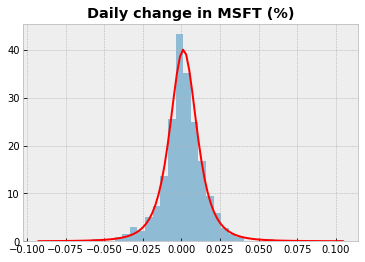

In [35]:
support = np.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Daily change in MSFT (%)", weight="bold");

In [36]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.022995132961478742

###  Our analytical VAR at 0.05 quantile is at -0.023, so with 95% confidence, our worst daily loss will not exceed 2.23%. For a 1M dollar investment, one-day Value at Risk is 0.023 * 1 M =$ 22300.

### Value at Risk using the Monte Carlo method

In [45]:
np.random.seed(42)
n_sims = 10000000
price=data.iloc[-1]["Adj Close"]
sim_returns = np.random.normal(mean, sigma, n_sims)
SimVAR = price*np.percentile(sim_returns, 5)
print('Simulated VAR is ', SimVAR)

Simulated VAR is  -3.5880134861620876
